# Gradient Descent

## Objective of this session

We have already learnt how to use Linear Regression and Logistic Regression models.

The code might seem quite easy and intuitive for you. And you might naturally ask:
- What's behind the ```.fit()``` function?
- Why sometimes it takes quite a bit for this ```.fit()``` function to finish running?

In this session, you will learn that the ```.fit()``` is the training of ML models, 
i.e. tuning of parameters for ML models. And the technique behind is called "Gradient Descent".

## Video

The corresponding video (in Chinese) for this notebook is [👉 available here on Bilibili](https://www.bilibili.com/video/BV1SY4y1G7o9/).
You can (and should) watch the video before diving into the details of gradient descent:


<iframe width="100%" height="500" src="//player.bilibili.com/player.html?aid=642485873&cid=764796592&page=1&high_quality=1&danmaku=0" 
scrolling="no" frameborder="0" sandbox="allow-top-navigation allow-same-origin allow-forms allow-scripts" allowfullscreen="true"> </iframe>



## Let's be playful ... to gain some intuition

- [Tensorflow Playground](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.00001&regularizationRate=0&noise=0&networkShape=&seed=0.71864&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=true&xSquared=true&ySquared=true&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
- [Gradient Descent Visualization](https://github.com/lilipads/gradient_descent_viz)
- [Optimization Algorithms Visualization](https://bl.ocks.org/EmilienDupont/aaf429be5705b219aaaf8d691e27ca87)

## Some mathematics ... to gain more insight

### Abstract

The idea behind gradient descent is simple - by gradually tuning parameters, such as slope ($m$) and the intercept ($b$) in our regression function $y = mx + b$, we minimize cost. 
By cost, we usually mean some kind of a function that tells us how far off our model predicted result. For regression problems we often use `mean squared error` (MSE) cost function. If we use gradient descent for the classification problem, we will have a different set of parameters to tune.

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2 \quad \textrm{where} \quad \hat{y_i} = mx_i + b $$

Now we have to figure out how to tweak parameters $m$ and $b$ to reduce MSE.

### Partial derivatives

We use partial derivatives to find how each individual parameter affects MSE, so that's where word _partial_ comes from. In simple words, we take the derivative with respect to $m$ and $b$ **separately**. Take a look at the formula below. It looks almost exactly the same as MSE, but this time we added f(m, b) to it. It essentially changes nothing, except now we can plug $m$ and $b$ numbers into it and calculate the result.

$$𝑓(𝑚,𝑏)= \frac{1}{n}\sum_{i=1}^{n}(y_i - (mx_i+b))^2$$

This formula (or better say function) is better representation for further calculations of partial derivatives. We can ignore sum for now and what comes before that and focus only on $y - (mx + b)^2$.

### Partial derivative with respect to $m$

With respect to $m$ means we derive parameter $m$ and basically ignore what is going on with $b$, or we can say its 0. To derive with respect to $m$ we will use chain rule.

$$ [f(g(x))]' = f'(g(x)) * g(x)' \: - \textrm{chain rule}$$

Chain rule applies when one function sits inside of another. If you're new to this, you'd be surprised that $()^2$ is outside function, and $y-(\boldsymbol{m}x+b)$ sits inside it. So, the chain rule says that we should take a derivative of outside function, keep inside function unchanged and then multiply by derivative of the inside function. Lets write these steps down:

$$ (y - (mx + b))^2 $$

1. Derivative of $()^2$ is $2()$, same as $x^2$ becomes $2x$
2. We do nothing with $y - (mx + b)$, so it stays the same
3. Derivative of $y - (mx + b)$ with respect to **_m_** is $(0 - (x + 0))$ or $-x$, because **_y_** and **_b_** are constants, they become 0, and derivative of **_mx_** is **_x_**
 
Multiply all parts we get following: $2 * (y - (mx+b)) * -x$. 

Looks nicer if we move -x to the left: $-2x *(y-(mx+b))$. There we have it. The final version of our derivative is the following:

$$\frac{\partial f}{\partial m} = \frac{1}{n}\sum_{i=1}^{n}-2x_i(y_i - (mx_i+b))$$

Here, $\frac{df}{dm}$ means we find partial derivative of function f (we mentioned it earlier) with respect to m. We plug our derivative to the summation and we're done.

### Partial derivative with respect to $b$

Same rules apply to the derivative with respect to b.

1. $()^2$ becomes $2()$, same as $x^2$ becomes $2x$
2. $y - (mx + b)$ stays the same
3. $y - (mx + b)$ becomes $(0 - (0 + 1))$ or $-1$, because **_y_** and **_mx_** are constants, they become 0, and derivative of **_b_** is 1

Multiply all the parts together and we get $-2(y-(mx+b))$

$$\frac{\partial f}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}-2(y_i - (mx_i+b))$$

### Final function

Few details we should discuss before jumping into code:

1. Gradient descent is an iterative process and with each iteration ($epoch$) we slightly minimizing MSE, so each time we use our derived functions to update parameters $m$ and $b$.
2. Because it's iterative, we should choose how many iterations we take, or make algorithm stop when we approach minima of MSE. In other words when algorithm is no longer improving MSE, we know it reached minimum.
3. Gradient descent has an additional parameter learning rate ($lr$), which helps control how fast or slow algorithm going towards minima of MSE

That's about it. So you can already understand that Gradient Descent for the most part is just process of taking derivatives and using them over and over to minimize function.

## Time to code!

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Linear regression With gradient descent

In [2]:
class LinearRegression:
    def __init__(self, learning_rate=0.0003, n_iters=3000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            y_predicted = np.dot(X, self.weights) + self.bias

            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted

{'lr': 0.0003, 'n_iters': 3000, 'weights': array([0.36114314, 0.15172482, 0.01138062, 0.07103796, 0.10143793,
       0.14812986, 0.09146885, 0.00270041]), 'bias': 0.014542612245156489}
0    -1.470137
1    -1.226722
2    -1.633534
3    -1.145394
4    -1.385705
        ...   
92    0.985388
93    1.125408
94    1.936285
95    1.776223
96    1.680470
Name: lpsa, Length: 97, dtype: float64


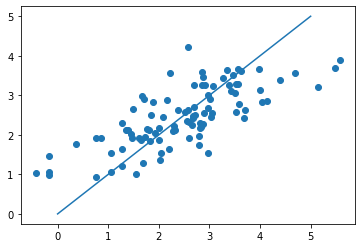

In [3]:
prostate = pd.read_table("../../data/prostate.data")
prostate.drop(prostate.columns[0], axis=1, inplace=True)

X = prostate.drop(["lpsa", "train"], axis=1)
y = prostate["lpsa"]

regressor = LinearRegression()

regressor.fit(X, y)
y_pred = regressor.predict(X)

print(regressor.__dict__)
print(y - y_pred)

plt.scatter(y, y_pred)
plt.plot([0, 5], [0, 5])
plt.show()

### Linear regression with stochastic gradient descent

In [4]:
class LinearRegressionWithSGD:
    def __init__(self, learning_rate=0.0003, n_iters=5000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        batch_size=5
        # stochastic gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            y_predicted = np.dot(X, self.weights) + self.bias
            
            indexes = np.random.randint(0, len(X), batch_size) # random sample
        
            Xs = np.take(X, indexes, axis=0)
            ys = np.take(y, indexes, axis=0)
            y_predicted_s = np.take(y_predicted, indexes)
            
            # compute gradients
            dw = (1 / batch_size) * np.dot(Xs.T, (y_predicted_s - ys))
            db = (1 / batch_size) * np.sum(y_predicted_s - ys)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted

{'lr': 0.0003, 'n_iters': 5000, 'weights': array([0.44621887, 0.21681393, 0.00106184, 0.09276936, 0.14121793,
       0.13383575, 0.11850267, 0.00491949]), 'bias': 0.02082323670870548}
0    -1.243304
1    -0.917891
2    -1.231244
3    -0.816323
4    -1.191451
        ...   
92    0.874544
93    0.737784
94    1.812310
95    1.562611
96    1.580348
Name: lpsa, Length: 97, dtype: float64


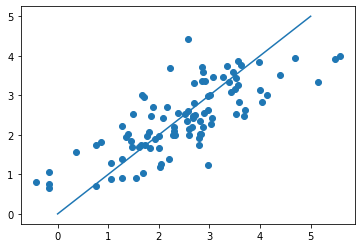

In [5]:
prostate = pd.read_table("../../data/prostate.data")
prostate.drop(prostate.columns[0], axis=1, inplace=True)

X = prostate.drop(["lpsa", "train"], axis=1)
y = prostate["lpsa"]

regressor = LinearRegressionWithSGD()

regressor.fit(X, y)
y_pred = regressor.predict(X)

print(regressor.__dict__)
print(y - y_pred)

plt.scatter(y, y_pred)
plt.plot([0, 5], [0, 5])
plt.show()

### Logistic regression with gradient descent

In [6]:
class LogisticRegression:

    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # init parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # gradient descent
        for _ in range(self.n_iters):
            # approximate y with linear combination of weights and x, plus bias
            linear_model = np.dot(X, self.weights) + self.bias
            # apply sigmoid function
            y_predicted = self._sigmoid(linear_model)

            # compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            # update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [7]:
heart = pd.read_csv("../../data/SA_heart.csv")
heart.famhist.replace(to_replace=['Present', 'Absent'], value=[1, 0], inplace=True)
heart.drop(['row.names'], axis=1, inplace=True)
X = heart.iloc[:, :-1]
y = heart.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regressor = LogisticRegression(learning_rate=0.0001, n_iters=1000)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
perf = sklearn.metrics.confusion_matrix(y_test, y_pred)
print("LR classification perf:\n", perf)

error_rate = np.mean(y_test != y_pred)
print("LR classification error rate:\n", error_rate)

LR classification perf:
 [[88  9]
 [40 16]]
LR classification error rate:
 0.3202614379084967


## Your turn 🚀

Modify ```LogisticRegression``` so that the training will use SGD instead of GD.


## At the frontier of Machine Learning Research [optional]

[Optimizers - EXPLAINED!](https://www.youtube.com/watch?v=mdKjMPmcWjY)


## Bibliography

- [Gradient Descent, Step-by-Step - StatQuest](https://www.youtube.com/watch?v=sDv4f4s2SB8)
- [Stochastic Gradient Descent, Clearly Explained!!! - StatQuest](https://www.youtube.com/watch?v=vMh0zPT0tLI) 
- http://43.142.12.204:12345/05-ML_04-Under-the-Hood.html
- http://43.142.12.204:9999/GradientDescentAnimation.html